In [3]:
%pip install -q huggingface_hub open_clip_torch


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!curl -O https://opendatasharing.s3.us-west-2.amazonaws.com/SkyScript/ckpt/SkyCLIP_ViT_L14_top50pct.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4281M  100 4281M    0     0  7197k      0  0:10:09  0:10:09 --:--:-- 8116k  0  0:09:14  0:02:25  0:06:49 3906k369M    0     0  7215k      0  0:10:07  0:05:36  0:04:31 4723k7190k      0  0:10:09  0:05:42  0:04:27 5955k0     0  7252k      0  0:10:04  0:09:00  0:01:04 8720k


In [4]:
from os.path import join

from huggingface_hub import hf_hub_download
import torch, open_clip
from PIL import Image
from IPython.display import display

In [5]:
model_name = 'ViT-L-14'
model, _, _ = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [6]:
ckpt_path = 'SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path)['state_dict']
ckpt = {k[len('module.'):]:v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
# model = model.cuda().eval()
model = model.eval()

---

In [7]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource, Scene, StatsTransformer
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm
import albumentations as A
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

In [8]:
def show_windows(img, windows, scores, figsize, title=''):
    from matplotlib import pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1, 1, squeeze=True, figsize=figsize)
    ax.imshow(img)
    ax.axis('off')
    # draw windows on top of the image
    for w, score in zip(windows, scores):
        p = patches.Polygon(w.to_points(), color='r', alpha=score * 0.5, linewidth=1)
        ax.add_patch(p)
    ax.autoscale()
    ax.set_title(title)
    plt.show()

def show_top_chips(chip_scores, raster_source, windows, top_inds=None, nrows=5, ncols=5, figsize=(12, 12), w_pad=-2.5, h_pad=-2.5):
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, ind in zip(axs.flat, top_inds):
        chip = raster_source.get_chip(windows[ind])
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

---

In [90]:
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_nw_18_060_20191019.tif m_3907507_nw_18_060_20191019.tif --request-payer requester
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_nw_18_060_20191019.tif m_3907506_nw_18_060_20191019.tif --request-payer requester
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_ne_18_060_20191019.tif m_3907506_ne_18_060_20191019.tif --request-payer requester
# !aws s3 cp s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_ne_18_060_20191015.tif m_3907507_ne_18_060_20191015.tif --request-payer requester

download: s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_nw_18_060_20191019.tif to ./m_3907507_nw_18_060_20191019.tif
download: s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_nw_18_060_20191019.tif to ./m_3907506_nw_18_060_20191019.tif
download: s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907506_ne_18_060_20191019.tif to ./m_3907506_ne_18_060_20191019.tif


In [9]:
rs = RasterioSource(uris=[
    'm_3907507_nw_18_060_20191019.tif', 
    'm_3907506_nw_18_060_20191019.tif', 
    'm_3907507_ne_18_060_20191015.tif', 
    'm_3907506_ne_18_060_20191019.tif', 
    ], 
    channel_order=[0, 1, 2])
# rs = RasterioSource('s3://naip-analytic/pa/2019/60cm/rgbir_cog/39075/m_3907507_ne_18_060_20191015.tif', allow_streaming=True)
# rs = RasterioSource(item.assets['image'].href, allow_streaming=True)
rs.shape, rs.dtype

2024-03-05 00:39:40:rastervision.core.data.utils.rasterio: INFO - Building VRT...
INFO:rastervision.core.data.utils.rasterio:Building VRT...


0...10...20...30...40...50...60...70...80...90...100 - done.


((12569, 36615, 3), dtype('uint8'))

In [ ]:
# img = rs[:, :]
# img.shape

In [10]:
scene = Scene('', raster_source=rs)
ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene,
    size=400,
    stride=200,
    padding=0,
    # transform=A.Resize(224, 224),
    transform=A.Resize(224, 224),
)
dl = DataLoader(ds, batch_size=16, num_workers=4)
len(ds)

11102

In [17]:
embs = []
with torch.inference_mode(), tqdm(dl, desc='Creating chip embeddings') as bar:
    for x, _ in bar:
        x = x.cuda()
        # _emb_1 = model.encode_image(x)
        # _emb_2 = model.encode_image(x.flip(2))
        # _emb_3 = model.encode_image(x.flip(3))
        # _emb_4 = model.encode_image(x.flip(2).flip(3))
        # emb = sum([_emb_1, _emb_2, _emb_3, _emb_4]) / 4
        emb = model.encode_image(x)
        embs.append(emb.cpu())
embs = torch.cat(embs, dim=0)
embs /= embs.norm(dim=-1, keepdim=True)
embs.shape

Creating chip embeddings:   0%|          | 0/694 [00:00<?, ?it/s]

torch.Size([11102, 768])

In [18]:
torch.save(embs, 'skyscript_naip_embeddings_400_200.pt')

In [11]:
embs = torch.load('skyscript_naip_embeddings_400_200.pt')
embs.shape

torch.Size([11102, 768])

In [80]:
embs = embs.clip(-0.1, 0.1)

In [36]:
# model = model.cpu()
# torch.cuda.empty_cache()

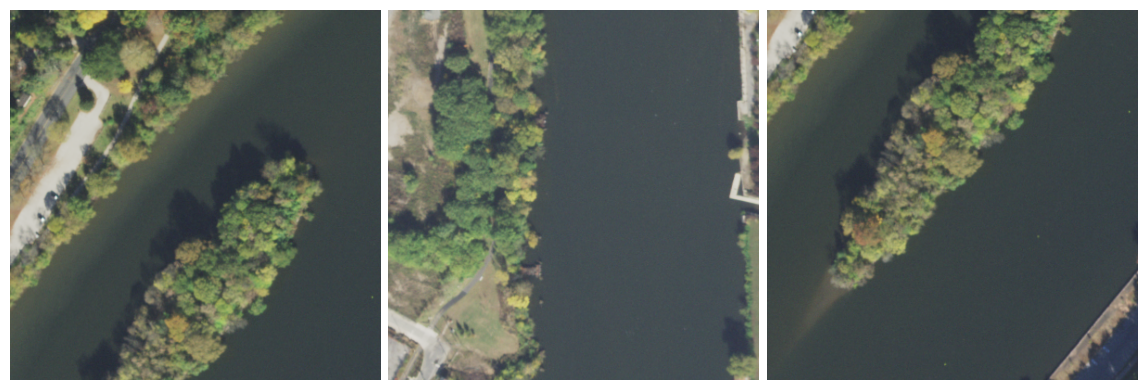

In [95]:
T = 0.01
text_queries = [
    # 'houses with swimming pools',
    'trees along a river bank',
    # 'power transmission lines',
    # 'running track',
    # 'baseball pitch near water',
    # 'runway',
    # 'power plant',
    # 'warehouses',
    # 'multi-lane road',
    # '1 tennis court',
    # 'satellite view of a skyscraper casting a shadow',
    # 'empty road',
]
assert len(text_queries) == 1
text = tokenizer(text_queries)
with torch.inference_mode():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.clip(-0.1, 0.1)
    text_features = text_features.cpu()
    chip_scores = torch.cosine_similarity(text_features, embs)
    # chip_scores = (chip_scores / T).softmax(dim=0)
    # chip_scores = chip_scores / chip_scores.max()
    
# show_windows(img, ds.windows, chip_scores, figsize=(10, 12))

# thresh = chip_scores.mean() + 4*chip_scores.std()
# top_inds = np.where(chip_scores > thresh)[0]
# top_vals = chip_scores[top_inds]
# top_inds = top_inds[np.argsort(top_vals).flip(0)]
top_inds = None
show_top_chips(chip_scores, rs, ds.windows, top_inds, nrows=1, ncols=3, figsize=(12, 12))

In [106]:
text_group1 = [
    'baseball',
    'baseball pitches',
    'sports pitch',
    'playground'
]
with torch.inference_mode():
    text_features1 = model.encode_text(tokenizer(text_group1))
    text_features1 /= text_features1.norm(dim=-1, keepdim=True)
    text_features1 = text_features1.clip(-0.1, 0.1)

In [109]:
text_group2 = [
    'river bank',
    'sandy beach',
    'airport',
    'warehouses'
]
with torch.inference_mode():
    text_features2 = model.encode_text(tokenizer(text_group2))
    text_features2 /= text_features2.norm(dim=-1, keepdim=True)
    text_features2 = text_features2.clip(-0.1, 0.1)

In [79]:
torch.cosine_similarity(embs[[6785]].clip(-0.1, 0.1), torch.stack([text_features1.squeeze(), text_features2.squeeze()]).clip(-0.1, 0.1))

tensor([0.3464, 0.0859])

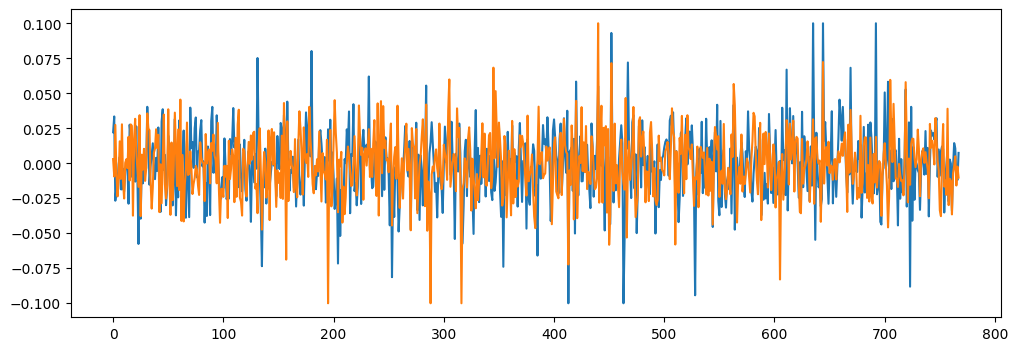

In [90]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(embs[6785])
# ax.plot((embs[6785] - text_features1.squeeze()))
ax.plot(text_features1.squeeze())
# ax.plot(text_features2.squeeze())
# ax.plot(embs[6785])
# ax.set_ylim((-0.1, 0.1))
plt.show()

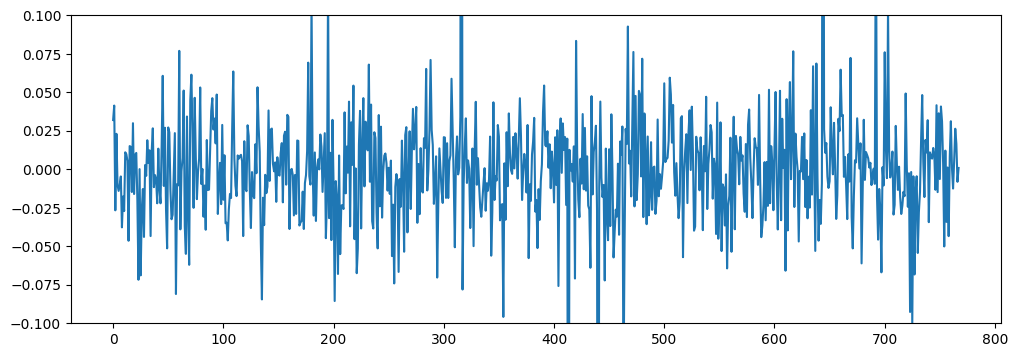

In [55]:
fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(embs[6785])
ax.plot((embs[6785] - text_features2.squeeze()))
# ax.plot(text_features1.squeeze())
# ax.plot(text_features2.squeeze())
ax.set_ylim((-0.1, 0.1))
# ax.plot(embs[6785])
plt.show()

In [96]:
from sklearn.decomposition import PCA

In [97]:
pca = PCA()

In [98]:
pca.fit(embs)

PCA()

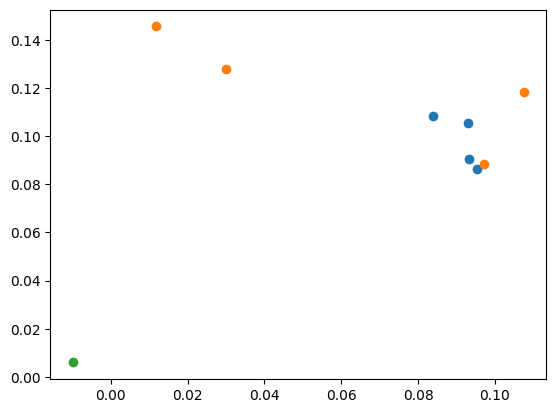

In [111]:
pca_emb = pca.transform(text_features1)
plt.scatter(pca_emb[:, 0], pca_emb[:, 1])
pca_emb = pca.transform(text_features2)
plt.scatter(pca_emb[:, 0], pca_emb[:, 1])
pca_emb = pca.transform(embs[6785].unsqueeze(0))
plt.scatter(pca_emb[:, 0], pca_emb[:, 1])
plt.show()

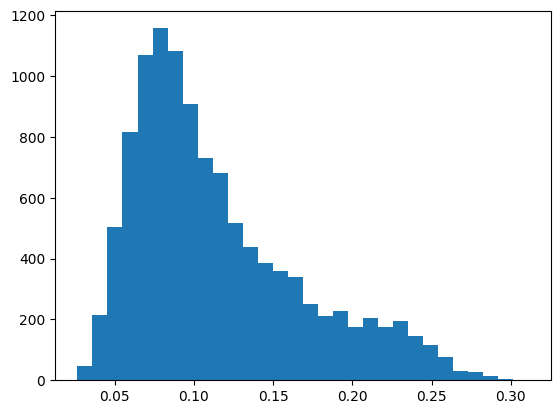

In [112]:
plt.hist(chip_scores, bins=30)
plt.show()

In [67]:
torch.allclose(torch.cosine_similarity(text_features, embs), torch.matmul(text_features, embs.T))

True

---

In [22]:
from rastervision.pipeline.file_system.utils import json_to_file
from rastervision.core.data import ClassConfig, boxes_to_geojson

In [25]:
geojson = boxes_to_geojson(
    ds.windows, [0] * len(ds), rs.crs_transformer, ClassConfig(names=text_queries), scores=chip_scores.tolist())

json_to_file(geojson, f'RemoteCLIP_naip_{text_queries[0]}.json')